# EEG Signal Preprocessing Notebook

## 1️⃣ Import Libraries & Set Paths
- Import Python packages: `numpy`, `pandas`, `matplotlib`, `scipy.signal`, `os`, `re`, `pathlib`
- Set raw data directory path
- Optional: set random seed for reproducibility

---

## 2️⃣ Understand Dataset
- Data format: `sXX_exXX_sXX.txt`
  - `s` = subject number  
  - `ex` = experiment number  
  - `s` = session number (only for ex01/ex02)  
- 4 EEG channels: **T7, F8, Cz, P4**  
- Sampling rate: **200 Hz**  
- Electrodes: **Gold Cup with Ten20 conductive paste**  
- Check for header row (`Sample, T7, F8, Cz, P4`)  
- Plan how to handle headers when loading the file

---

## 3️⃣ Load EEG Data
- Function to read any EEG file:
  - Skip headers or non-numeric columns
  - Return `sample_idx` (column 0) and `eeg_data` (columns 1–4)
- Ensure flexibility to load files from any experiment

---

## 4️⃣ Initial Visualization
- Plot raw EEG signals
  - Stack channels with offsets
  - Optionally plot individual channels
- Observe noise, artifacts, offsets, and amplitude differences

---

## 5️⃣ Signal Preprocessing
**5a. Offset / Detrend (Optional)**  
- Remove DC offset or baseline drift if needed  

**5b. Bandpass Filtering**  
- Apply **Butterworth 1–40 Hz filter**  
- Use `filtfilt` for zero-phase distortion  

**5c. Optional Notch Filter**  
- Remove **50 Hz line noise** if present  

---

## 6️⃣ Artifact Handling
- Identify/remove spikes or unusual peaks
- Optional: simulate motion artifacts for modeling

---

## 7️⃣ Feature Extraction
- **Time-domain features:** RMS, Peak-to-Peak, Mean, Std  
- **Frequency-domain features:** FFT, band power (delta, theta, alpha, beta)

---

## 8️⃣ Parameter Sweep / System Modeling
- Add Gaussian noise at varying levels
- Adjust filter cutoffs and observe effects on signal quality
- Visualize impact across channels

---

## 9️⃣ Save Preprocessed Data
- Save filtered EEG arrays for future analysis
- Maintain folder structure:
  - `raw/`  
  - `filtered/`  
  - `segmented/` (if applicable)

---

## Notes / References
- Jurcak V, Tsuzuki D, Dan I. 10/20, 10/10, and 10/5 systems revisited: their validity as relative head-surface-based positioning systems. Neuroimage. 2007 Feb 15;34(4):1600-11.
Altahat SH. Robust EEG Channel Set for Biometric Application (Doctoral dissertation, University of Canberra).
Ravi KV, Palaniappan R. A minimal channel set for individual identification with EEG biometric using genetic algorithm. InInternational Conference on Computational Intelligence and Multimedia Applications (ICCIMA 2007) 2007 Dec 13 (Vol. 2, pp. 328-332). IEEE.
Marcel S, Millán JD. Person authentication using brainwaves (EEG) and maximum a posteriori model adaptation. IEEE transactions on pattern analysis and machine intelligence. 2007 Feb 20;29(4):743-52.
World Medical Association. World Medical Association Declaration of Helsinki. Ethical principles for medical research involving human subjects. Bulletin of the World Health Organization. 2001;79(4):373.


## 1️⃣ Import Libraries and Set Paths

In [26]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

## 3️⃣ Load EEG Data & 4️⃣ Initial Visualization

In [27]:
# Define a general function to open any EEG data file given its path
def load_eeg_file(exp_folder, filename):
    """
    Load an EEG data file based on its experiment folder and filename.

    Parameters:
    ------------
    exp_folder: str or Path 
        Path to the experiment folder (e.g., "data\auditory-evoked-potential-eeg-biometric-dataset-1.0.0\Raw_Data\ex01")
    
    filename: str 
        Name of the file to load (e.g., "s01_ex01_s01.txt")
    
    Returns:
    --------
    sample_idx : np.ndarray
        Array of sample indices
    eeg : np.ndarray
        EEG signal array (num_samples x num_channels)
    """
    exp_folder = Path(exp_folder)
    file_path = exp_folder / filename

    # Load file
    try:
        df = pd.read_csv(file_path, sep=",")
    except Exception as e:
        raise ValueError(f"Could not load file {file_path}: {e}")

    # Split sample index and EEG channels
    sample_idx = df.iloc[:, 0].to_numpy()
    eeg = df.iloc[:, 1:5].to_numpy()  # 4 EEG channels

    return sample_idx, eeg
# -----------------------------------------------------------------------------------------------------------------------------------------------------
# Define a function to plot EEG signals for all or selected channels
def plot_eeg(sample_idx, eeg, channels_to_plot=None, channel_names=None):
    """
    Plot EEG signals with optional channel selection and offsets.

    Parameters:
    - sample_idx: array of sample indices
    - eeg: numpy array of shape (n_samples, n_channels)
    - channels_to_plot: list of channel indices to plot (0-based). If None, plot all.
    - channel_names: list of names for channels. If None, default to Ch1, Ch2...
    """
    n_channels = eeg.shape[1]

    if channels_to_plot is None:
        channels_to_plot = list(range(n_channels))

    if channel_names is None:
        channel_names = [f"Ch{i+1}" for i in range(n_channels)]

    plt.figure(figsize=(12, 6))
    
    for i, ch_idx in enumerate(channels_to_plot):
        plt.plot(sample_idx, eeg[:, ch_idx] + i*50, label=channel_names[ch_idx])  # offset

    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude + Offset (+ 50 uV)")
    plt.title("EEG Signals")
    plt.legend()
    plt.show()

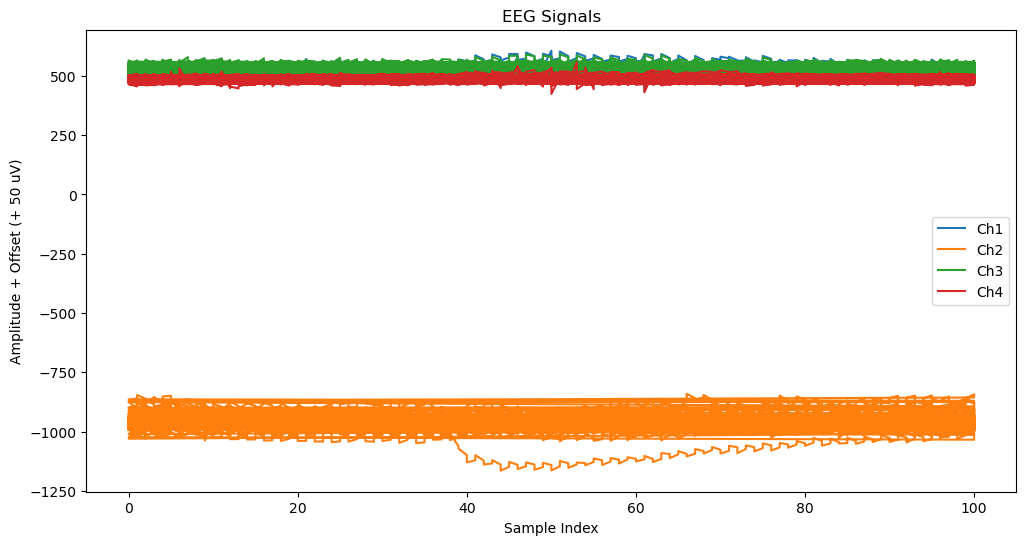

In [28]:
# Define the path to the raw data directory
raw = Path("data") / "auditory-evoked-potential-eeg-biometric-dataset-1.0.0" / "Raw_Data"

# Load any file from ex09
sample_idx, eeg = load_eeg_file(raw / "ex01", "s01_ex01_s01.txt")

# Plot all channels
plot_eeg(sample_idx, eeg)


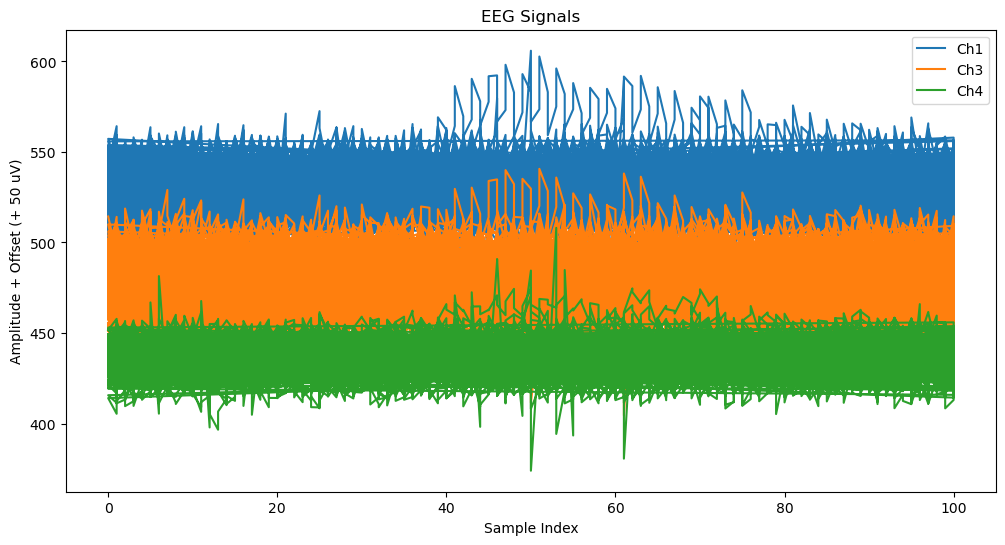

In [29]:
# Plot all channels
plot_eeg(sample_idx, eeg, channels_to_plot=[0, 2, 3])

## 5️⃣ Signal Pre-processing

Its clear that the raw data has noise. We can intoduce a bandpass filter to remove low frequencies and very high frequencies. 

In [35]:
# Bandpass filter function
def bandpass_filter(eeg, lowcut, highcut, fs, order=4):
    """
    Apply a zero-phase Butterworth bandpass filter to EEG data.
    
    Parameters
    ----------
    eeg : np.ndarray
        2D array (samples x channels)
    lowcut : float
        Lower cutoff frequency (Hz)
    highcut : float
        Upper cutoff frequency (Hz)
    fs : float
        Sampling rate (Hz)
    order : int, optional
        Filter order (default=2)
    
    Returns
    -------
    eeg_filtered : np.ndarray
        Filtered EEG data (same shape)
    """
    
    # Check if eeg is 1D (single channel) and reshape
    if eeg.ndim == 1:
        eeg = eeg[:, np.newaxis]
    
    # Normalize cutoff frequencies to Nyquist
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Compute minimum required length for filtfilt
    padlen = 3 * (max(len(a), len(b)) - 1)
    if eeg.shape[0] <= padlen:
        raise ValueError(
            f"Signal too short for filtfilt! "
            f"Samples = {eeg.shape[0]}, required > {padlen}."
        )
    
    # Apply filter channel-wise
    eeg_filtered = np.zeros_like(eeg)
    for ch in range(eeg.shape[1]):
        eeg_filtered[:, ch] = filtfilt(b, a, eeg[:, ch])
    
    return eeg_filtered

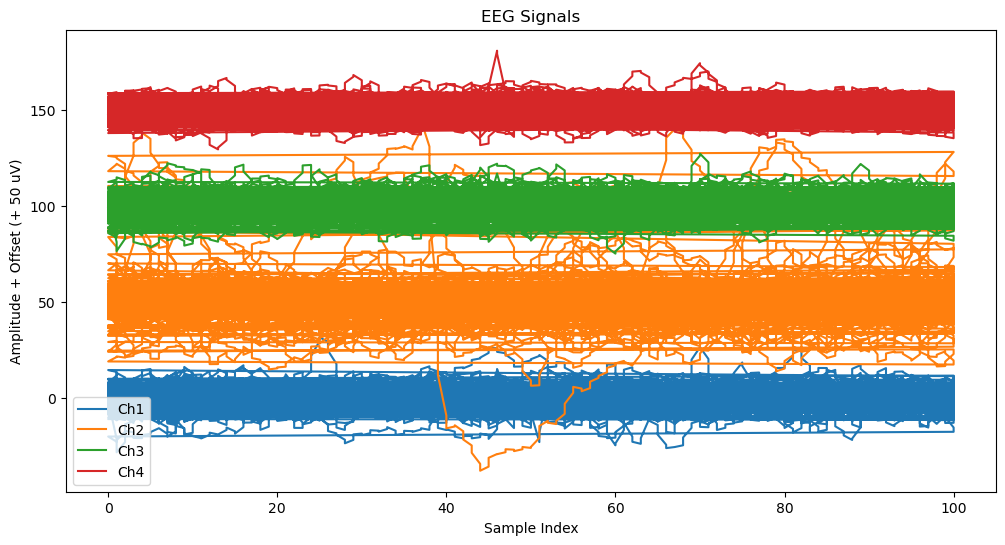

In [39]:
# Define the known sampling frequency
fs = 200 # Hz 
lowcut = 1.0 # Hz
highcut = 40.0 # Hz

# Filter the EEG Signal
eeg_filtered = bandpass_filter(eeg, lowcut, highcut, fs, order=4)
# plot the filtered signal
plot_eeg(sample_idx, eeg_filtered)

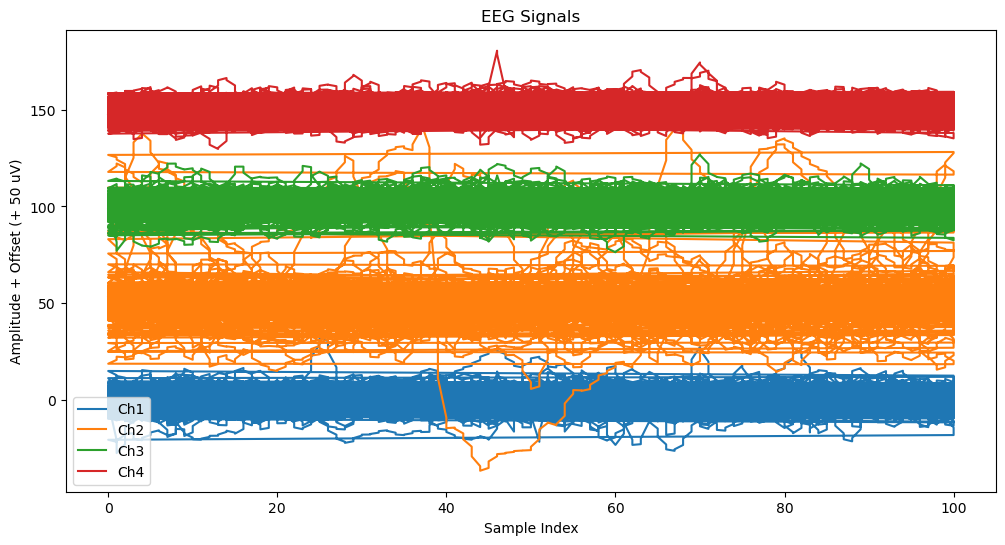

In [42]:
from scipy.signal import iirnotch

fs = 200
f0 = 50  # frequency to remove
Q = 30   # quality factor, higher = narrower notch

b, a = iirnotch(f0, Q, fs)
eeg_notched = filtfilt(b, a, eeg_filtered, axis=0)  # apply channel-wise
plot_eeg(sample_idx, eeg_notched)

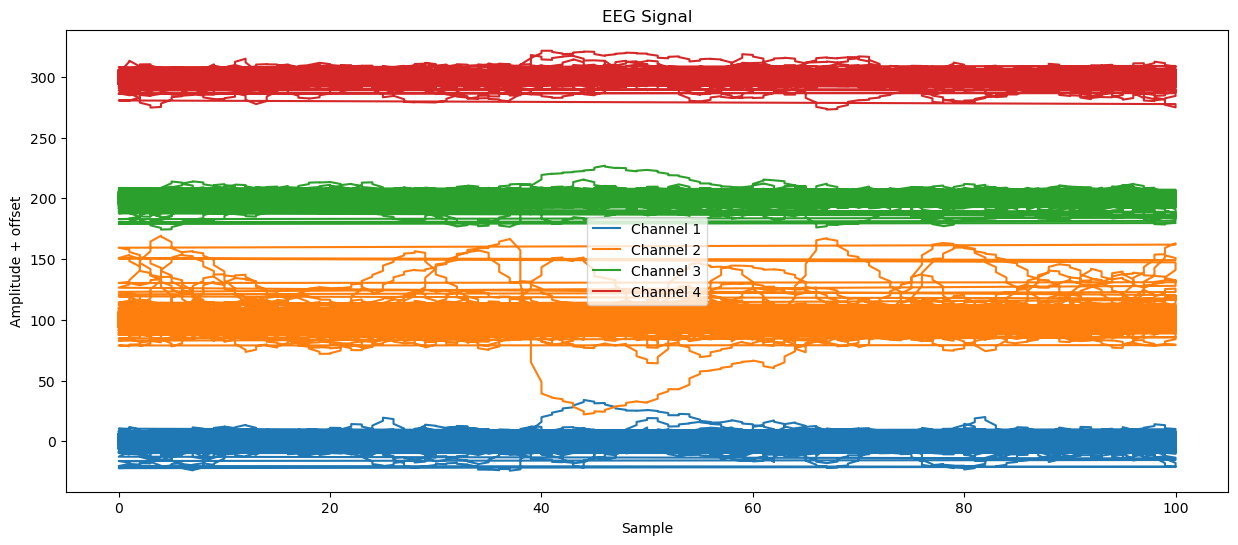

In [ ]:
# EEG Pre-processing Pipeline
from scipy.signal import butter, filtfilt, iirnotch

# -----------------------------
# 1️⃣ Bandpass Filter Function
# -----------------------------
def bandpass_filter(eeg, lowcut=1.0, highcut=40.0, fs=200, order=1):
    """
    Apply a Butterworth bandpass filter to EEG data.
    
    eeg: np.array, shape (samples, channels)
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, eeg, axis=0)  # apply channel-wise
    return filtered

# -----------------------------
# 2️⃣ Notch Filter Function
# -----------------------------
def notch_filter(eeg, fs=200, f0=50.0, Q=30):
    """
    Apply a notch filter at f0 Hz to remove powerline noise.
    
    eeg: np.array, shape (samples, channels)
    """
    b, a = iirnotch(f0, Q, fs)
    filtered = filtfilt(b, a, eeg, axis=0)
    return filtered

# -----------------------------
# 3️⃣ Optional Smoothing
# -----------------------------
def smooth_eeg(eeg, window=5):
    """
    Apply moving average smoothing to EEG data.
    
    eeg: np.array, shape (samples, channels)
    """
    import pandas as pd
    return pd.DataFrame(eeg).rolling(window=window, center=True).mean().to_numpy()

# -----------------------------
# 4️⃣ Re-referencing
# -----------------------------
def re_reference(eeg):
    """
    Subtract the mean across channels to reduce common noise.
    
    eeg: np.array, shape (samples, channels)
    """
    return eeg - np.mean(eeg, axis=1, keepdims=True)

# -----------------------------
# 5️⃣ Plot EEG
# -----------------------------
def plot_eeg(sample_idx, eeg, channels_to_plot=None, offset=100):
    """
    Plot EEG channels with offset.
    
    sample_idx: np.array
    eeg: np.array, shape (samples, channels)
    channels_to_plot: list of channel indices to plot
    offset: vertical spacing between channels
    """
    if channels_to_plot is None:
        channels_to_plot = range(eeg.shape[1])
    
    plt.figure(figsize=(15, 6))
    
    for i, ch in enumerate(channels_to_plot):
        plt.plot(sample_idx, eeg[:, ch] + i*offset, label=f"Channel {ch+1}")
    
    plt.xlabel("Sample")
    plt.ylabel("Amplitude + offset")
    plt.title("EEG Signal")
    plt.legend()
    plt.show()

# -----------------------------
# 6️⃣ Full Preprocessing Pipeline
# -----------------------------
def preprocess_eeg(eeg, fs=200, smooth=False):
    """
    Run full preprocessing: bandpass, notch, optional smoothing, and re-referencing.
    """
    eeg = bandpass_filter(eeg, fs=fs)
    eeg = notch_filter(eeg, fs=fs)
    
    if smooth:
        eeg = smooth_eeg(eeg)
    
    eeg = re_reference(eeg)
    return eeg

# -------------------------------
# View the pre-processing pipeline
fs = 200  # sampling rate
eeg_processed = preprocess_eeg(eeg, fs=fs, smooth=False)
plot_eeg(sample_idx, eeg_processed)


In [ ]:
# Path to filtered file
filtered_file = raw.parent / "Filtered_Data" / "s01_ex01_s01.csv"
print(f"Filtered file path: {filtered_file}")

# Load
df_filtered = pd.read_csv(filtered_file, delimiter=",")  # or ',' depending on the file
sample_idx_filtered = df_filtered.iloc[:, 0].to_numpy()
eeg_filtered_reference = df_filtered.iloc[:, 1:].to_numpy()

print(eeg_pipeline.shape, eeg_filtered_reference.shape)

Filtered file path: data\auditory-evoked-potential-eeg-biometric-dataset-1.0.0\Filtered_Data\s01_ex01_s01.csv
(37481, 4) (24000, 4)


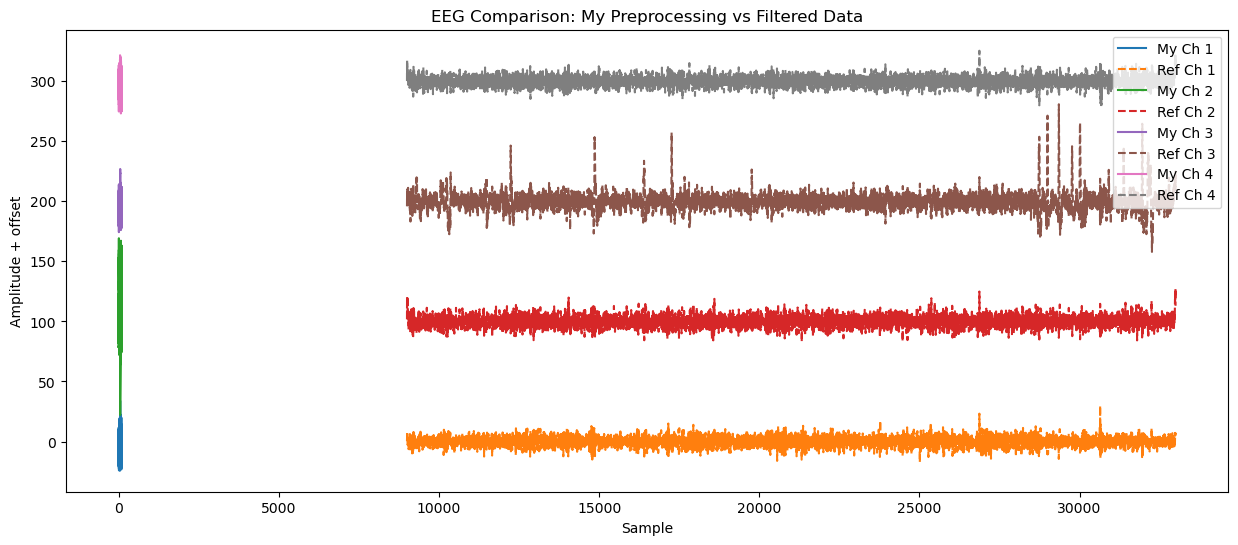

In [50]:

# Apply our preprocessing pipeline without smoothing
eeg_pipeline = preprocess_eeg(eeg, fs=fs, smooth=False)

# Plot comparison for selected channels
channels_to_plot = [0, 1, 2, 3]  # T7, F8, Cz, P4

plt.figure(figsize=(15,6))
for i, ch in enumerate(channels_to_plot):
    plt.plot(sample_idx, eeg_pipeline[:, ch] + i*100, label=f"My Ch {ch+1}")
    plt.plot(sample_idx_filtered, eeg_filtered_reference[:, ch] + i*100, '--', label=f"Ref Ch {ch+1}")

plt.xlabel("Sample")
plt.ylabel("Amplitude + offset")
plt.title("EEG Comparison: My Preprocessing vs Filtered Data")
plt.legend()
plt.show()
